In [1]:
# Set up
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv(r'data\fake_job_postings.csv')

# train dataset: 60% of the data, validation dataset: 20% of the data, test dataset: 20% of the data
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)  

# Display the sizes of the datasets
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Separate the real and fake job postings
fake_df = train_df[train_df['fraudulent'] == 1]
real_df = train_df[train_df['fraudulent'] == 0]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\15221\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15221\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\15221\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Training set size: 10728
Validation set size: 3576
Test set size: 3576


In [2]:
""" First approach, apply n grams to determine the most common words on real and fake jobs """

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to tokenize, remove stop words and generate n-grams
def tokenize_remove_stopwords_and_generate_ngrams(text, n):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum() and token not in stop_words]
    if n == 1:
        return tokens  
    else:
        return list(ngrams(tokens, n)) 

# Generate unigrams (n=1), bigrams (n=2), and trigrams (n=3) for both fake and real job descriptions
fake_job_unigrams = fake_df['description'].apply(lambda x: tokenize_remove_stopwords_and_generate_ngrams(x, n=1)).sum()
real_job_unigrams = real_df['description'].apply(lambda x: tokenize_remove_stopwords_and_generate_ngrams(x, n=1)).sum()

fake_job_bigrams = fake_df['description'].apply(lambda x: tokenize_remove_stopwords_and_generate_ngrams(x, n=2)).sum()
real_job_bigrams = real_df['description'].apply(lambda x: tokenize_remove_stopwords_and_generate_ngrams(x, n=2)).sum()

fake_job_trigrams = fake_df['description'].apply(lambda x: tokenize_remove_stopwords_and_generate_ngrams(x, n=3)).sum()
real_job_trigrams = real_df['description'].apply(lambda x: tokenize_remove_stopwords_and_generate_ngrams(x, n=3)).sum()

# Count n-gram frequencies
fakejob_unigram_freq = Counter(fake_job_unigrams)
realjob_unigram_freq = Counter(real_job_unigrams)

fakejob_bigram_freq = Counter(fake_job_bigrams)
realjob_bigram_freq = Counter(real_job_bigrams)

fakejob_trigram_freq = Counter(fake_job_trigrams)
realjob_trigram_freq = Counter(real_job_trigrams)


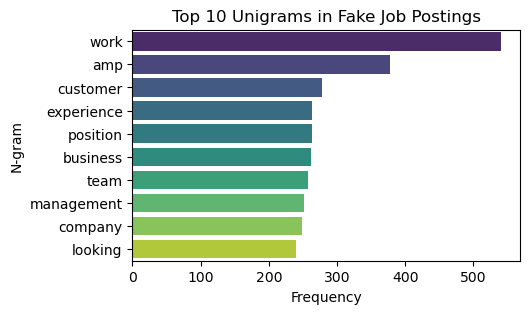

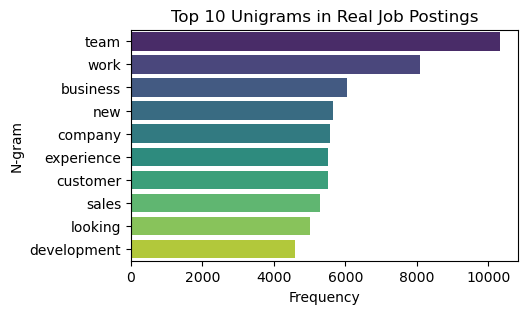

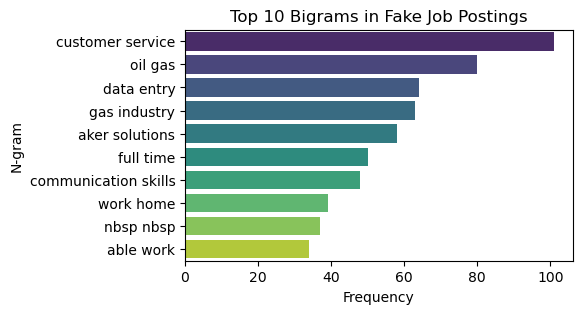

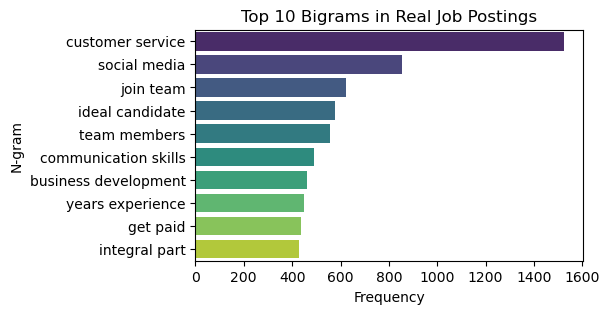

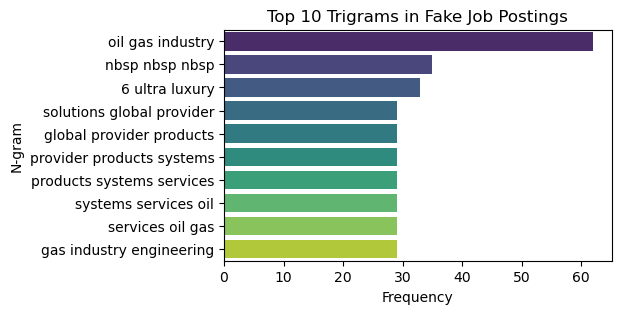

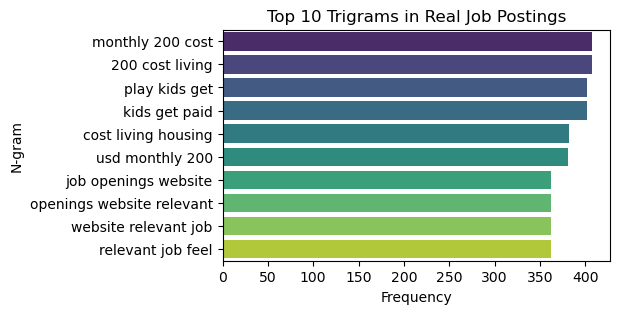

In [3]:
def plot_top_ngrams(ngram_freq, title, n=10):
    """Plot the top n n-grams by frequency."""
    ngrams, counts = zip(*ngram_freq.most_common(n))
    ngrams = [' '.join(gram) if isinstance(gram, tuple) else gram for gram in ngrams]
    
    plt.figure(figsize=(5, 3))
    sns.barplot(x=counts, y=ngrams, hue=ngrams, palette='viridis', dodge=False, legend=False)
    plt.title(f"Top {n} {title}")
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.show()

plot_top_ngrams(fakejob_unigram_freq, "Unigrams in Fake Job Postings")
plot_top_ngrams(realjob_unigram_freq, "Unigrams in Real Job Postings")
plot_top_ngrams(fakejob_bigram_freq, "Bigrams in Fake Job Postings")
plot_top_ngrams(realjob_bigram_freq, "Bigrams in Real Job Postings")
plot_top_ngrams(fakejob_trigram_freq, "Trigrams in Fake Job Postings")
plot_top_ngrams(realjob_trigram_freq, "Trigrams in Real Job Postings")

In [4]:
"""Second approach, investigate what data is missing in real and fake job postings"""

# Function to calculate the missing data percentage for each column in the dataset
def calculate_missing_percentage(df, columns):
    missing_data = {}
    total_rows = len(df)
    for column in columns:
        missing_count = df[column].isnull().sum()
        missing_percentage = (missing_count / total_rows) * 100
        missing_data[column] = missing_percentage
    return missing_data

# select features which might be useful to determine if a job posting is real or fake
columns = ['location', 'department', 'salary_range', 'company_profile', 
                      'description', 'requirements', 'benefits', 'telecommuting', 
                      'has_company_logo', 'has_questions', 'employment_type', 
                      'required_experience', 'required_education', 'industry', 'function']

# Calculate missing data percentages for real and fake job postings
real_missing_data = calculate_missing_percentage(real_df, columns)
fake_missing_data = calculate_missing_percentage(fake_df, columns)
real_missing_df = pd.DataFrame(list(real_missing_data.items()), columns=['Column', 'Missing_Percentage']).sort_values(by='Missing_Percentage', ascending=False)
fake_missing_df = pd.DataFrame(list(fake_missing_data.items()), columns=['Column', 'Missing_Percentage']).sort_values(by='Missing_Percentage', ascending=False)

# Sort columns in the same order for both real and fake job postings
sorted_columns = real_missing_df['Column'].tolist()  # Use real job columns as the base order
fake_missing_df = fake_missing_df.set_index('Column').reindex(sorted_columns).reset_index()


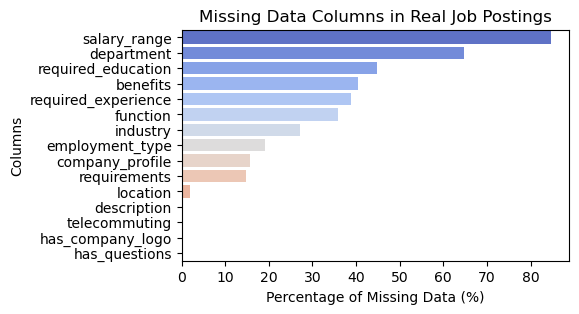

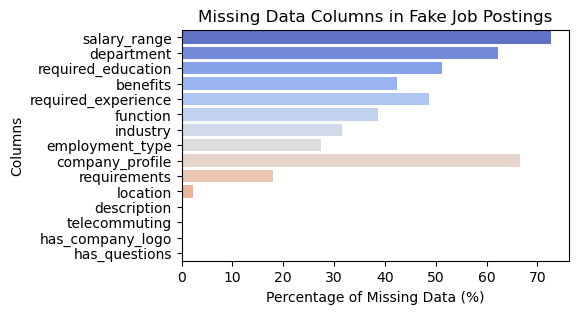

In [5]:
def plot_missing_data(missing_df, title):
    plt.figure(figsize=(5, 3))
    sns.barplot(x='Missing_Percentage', y='Column', hue='Column', data=missing_df, palette='coolwarm', dodge=False, legend=False)
    plt.title(title)
    plt.xlabel('Percentage of Missing Data (%)')
    plt.ylabel('Columns')
    plt.show()

plot_missing_data(real_missing_df, 'Missing Data Columns in Real Job Postings')
plot_missing_data(fake_missing_df, 'Missing Data Columns in Fake Job Postings')


In [6]:
""" Third approach, apply POS tagging to determine the most common POS tags on real and fake jobs"""
# Function to count POS tags (nouns, adjectives, verbs, adverbs)
def count_pos_tags(text):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    pos_counts = nltk.FreqDist(tag for word, tag in tagged)
    
    # Count different POS categories
    noun_count = pos_counts['NN'] + pos_counts['NNS'] + pos_counts.get('NNP', 0) + pos_counts.get('NNPS', 0)
    adjective_count = pos_counts['JJ'] + pos_counts.get('JJR', 0) + pos_counts.get('JJS', 0)
    verb_count = pos_counts.get('VB', 0) + pos_counts.get('VBD', 0) + pos_counts.get('VBG', 0) + pos_counts.get('VBN', 0) + pos_counts.get('VBP', 0) + pos_counts.get('VBZ', 0)
    adverb_count = pos_counts.get('RB', 0) + pos_counts.get('RBR', 0) + pos_counts.get('RBS', 0)
    
    return noun_count, adjective_count, verb_count, adverb_count

# List of columns to analyze
columns = ['company_profile', 'description', 'requirements', 'benefits']

# Apply POS tagging and count nouns, adjectives, verbs, and adverbs for each column
for column in columns:
    train_df[[f'{column}_noun', f'{column}_adjective', f'{column}_verb', f'{column}_adverb']] = train_df[column].apply(
        lambda x: pd.Series(count_pos_tags(str(x)))
    )

# Compare average counts for fake and real job postings across all columns
pos_comparison = {}
for column in columns:
    pos_comparison[column] = train_df.groupby('fraudulent').agg({
        f'{column}_noun': 'mean',
        f'{column}_adjective': 'mean',
        f'{column}_verb': 'mean',
        f'{column}_adverb': 'mean'
    })


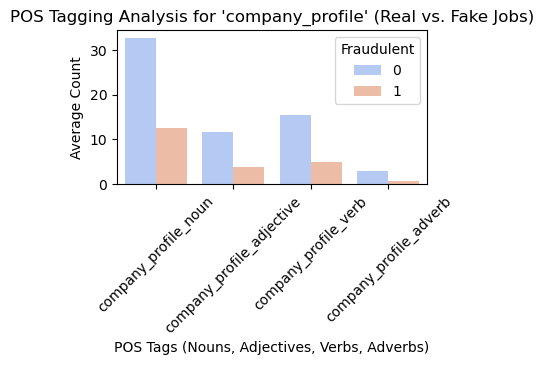

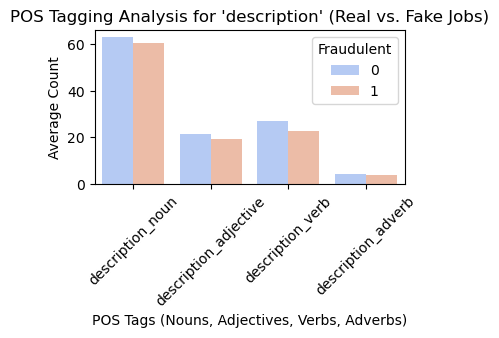

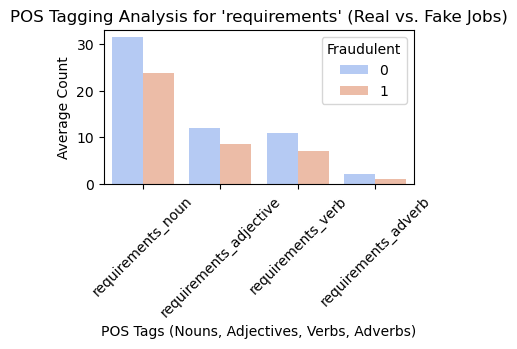

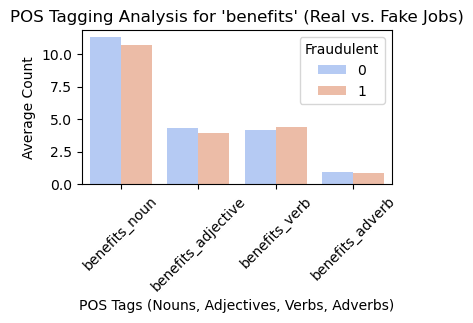

In [10]:
# Function to visualize POS comparison between fake and real jobs for each column
plt.rcParams['font.family'] = 'DejaVu Sans'
def visualize_pos_comparison(pos_comparison):
    for column, comparison_df in pos_comparison.items():
        comparison_df = comparison_df.reset_index()  # Reset index for easy plotting
        comparison_df = comparison_df.melt(id_vars='fraudulent', var_name='POS', value_name='Average Count')

        plt.figure(figsize=(4, 2))
        sns.barplot(x='POS', y='Average Count', hue='fraudulent', data=comparison_df, palette='coolwarm')
        plt.title(f"POS Tagging Analysis for '{column}' (Real vs. Fake Jobs)")
        plt.xlabel('POS Tags (Nouns, Adjectives, Verbs, Adverbs)')
        plt.ylabel('Average Count')
        plt.xticks(rotation=45)
        plt.legend(title='Fraudulent')
        plt.show()

# Visualize the POS comparison
visualize_pos_comparison(pos_comparison)